# Pricing and Hedging of Exotic Options
Redwan Mekrami



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
T = 1
r = 0.02
steps = 10
rho = -0.8

Npaths = 10000
dt = T/steps

W = np.random.randn(Npaths,steps)
Z_X = np.random.randn(Npaths,steps)  
Z_V = rho * Z_X + np.sqrt(1-rho**2)*W

In [3]:
def generate_paths_bs(S = 100, sigma = 0.3, scheme_asset = 'Euler'):
    size = (Npaths, steps)
    X_bs = np.zeros(size)
    X_bs[:,0] = S
    if(scheme_asset == 'Euler'):
      for t in range(steps-1):
        X_bs[:, t+1] = X_bs[:,t] *( 1 + r*dt+ sigma *np.sqrt(dt) * Z_X[:,t])
    if(scheme_asset == 'Milstein'):
      for t in range(steps-1):
        X_bs[:, t+1] = X_bs[:,t] *( 1 + r*dt+ sigma *np.sqrt(dt) * Z_X[:,t] + (0.5*(sigma**2)*dt * (Z_X[:,t]**2 - 1)) )
    return X_bs

def generate_paths_heston(S = 100, kappa = 4, theta = 0.3, v_0 = 0.3, xi = 0.9, scheme_asset = 'Euler', scheme_vol = 'Euler'):
    size = (Npaths, steps)
    X = np.zeros(size)
    V = np.zeros(size)
    X[:,0] = S
    V[:,0] = v_0
    for t in range(steps-1): 
      if(scheme_asset == 'Euler'):
        X[:,t+1] = X[:,t] * (1 + r*dt+ np.sqrt(np.maximum(V[:,t], 0) *dt) * Z_X[:,t])
      if(scheme_asset == 'Milstein'):
        X[:,t+1] = X[:,t] * ( 1 + r*dt+ (np.sqrt(np.maximum(V[:,t], 0) *dt) * Z_X[:,t]) + (0.5 * np.maximum(V[:,t], 0)* dt * ((Z_X[:,t]**2) - 1)) )
      if(scheme_vol == 'Euler'):
        V[:,t+1] = V[:,t] + kappa * (theta - np.maximum(V[:,t], 0))*dt + ( xi * np.sqrt(np.maximum(V[:,t], 0) * dt) * Z_V[:,t])
      if(scheme_vol == 'Milstein'):
        V[:,t+1] = V[:,t] + (kappa * dt * (theta - np.maximum(V[:,t], 0))) + (xi * np.sqrt(np.maximum(V[:,t], 0) * dt) * Z_V[:,t]) + (0.25 * (xi**2) * dt * ((Z_V[:,t]**2) - 1))
    return X, V



In [4]:
def binary_call_payoff(path, K = 100, T = 1):
    '''
      Compute the payoff of a Binary call option
      Args:
          path : 
            path of the underlying
          r:
            Risk-free interest rate
          T:
            Maturity
      Returns:
          The payoff of a Binary Call
      '''
    S_T = path[:,-1]
    Z = np.maximum(S_T>100, 0)
    return(np.exp(-r*T) *Z)

def binary_put_payoff(path, K = 100, T = 1):
    '''
      Compute the payoff of a Binary put option
      Args:
          path : 
            path of the underlying
          r:
            Risk-free interest rate
          T:
            Maturity
      Returns:
          The payoff of a Binary Put
      '''
    S_T = path[:,-1]
    Z = np.maximum(S_T<100, 0)
    return(np.exp(-r*T) * Z)

def asian_call_payoff(path, K = 100, T = 1):
    '''
      Compute the payoff of a Asian Call option
      Args:
          path : 
            path of the underlying
          r:
            Risk-free interest rate
          T:
            Maturity
      Returns:
          The payoff of a Asian Call
      '''
    S_T = np.mean(path, axis = 1)
    Z = np.maximum(S_T-K, 0)
    return(np.exp(-r*T) * Z)

def asian_put_payoff(path, K = 100, T = 1):
    '''
      Compute the payoff of a Asian put option
      Args:
          path : 
            path of the underlying
          r:
            Risk-free interest rate
          T:
            Maturity
      Returns:
          The payoff of an Asian Put
      '''
    S_T = np.mean(path, axis = 1)
    Z = np.maximum(K-S_T, 0)
    return(np.exp(-r*T) * Z)


def up_and_in_call_payoff(path, K = 100, barrier = 120, T = 1):
    '''
      Compute the payoff of a Up and In Call option
      Args:
          path : 
            path of the underlying
          r:
            Risk-free interest rate
          T:
            Maturity
          barrier:
            The option Barrier
      Returns:
          The payoff of an Up and In Call
      '''
    S_T = path[:,-1]
    S_max = np.max(path, axis = 1)
    Z = np.maximum(S_T-K, 0) * (S_max>barrier)
    return(np.exp(-r*T) * Z)


def down_and_in_put_payoff(path, K = 100, barrier = 90, T = 1):
    '''
      Compute the payoff of a Up and In Call option
      Args:
          path : 
            path of the underlying
          r:
            Risk-free interest rate
          T:
            Maturity
          barrier:
            The option Barrier
      Returns:
          The payoff of an Up and In Call
      '''
    S_T = path[:,-1]
    S_min = np.min(path, axis = 1)
    Z = np.maximum(K - S_T, 0) * (S_min < barrier)
    return(np.exp(-r*T) * Z)


payoff_list = [binary_call_payoff, binary_put_payoff, asian_call_payoff, asian_put_payoff, up_and_in_call_payoff, down_and_in_put_payoff]

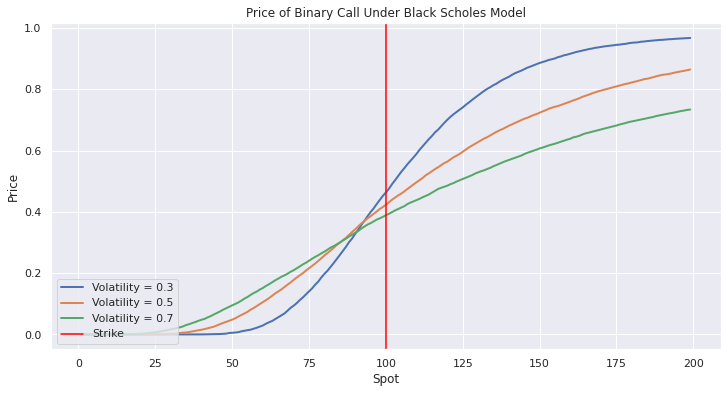

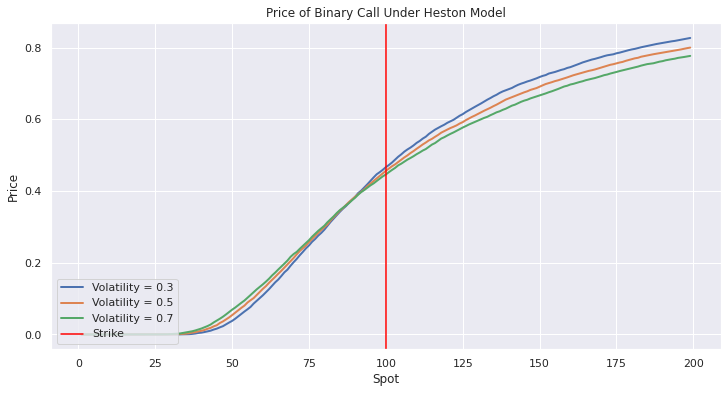

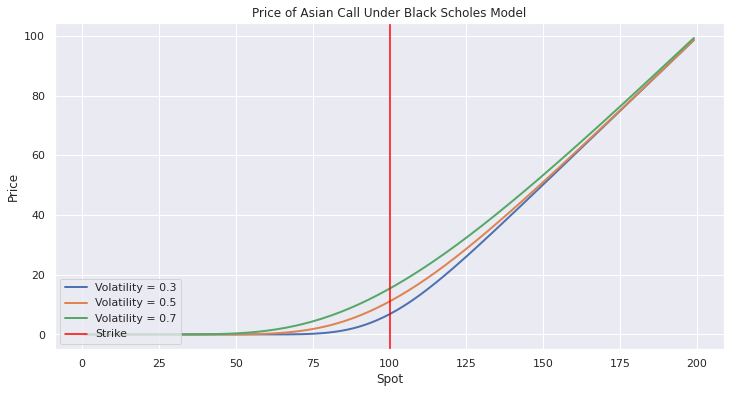

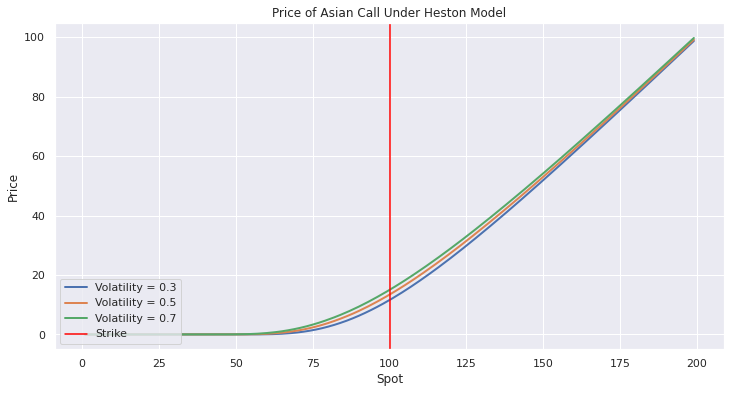

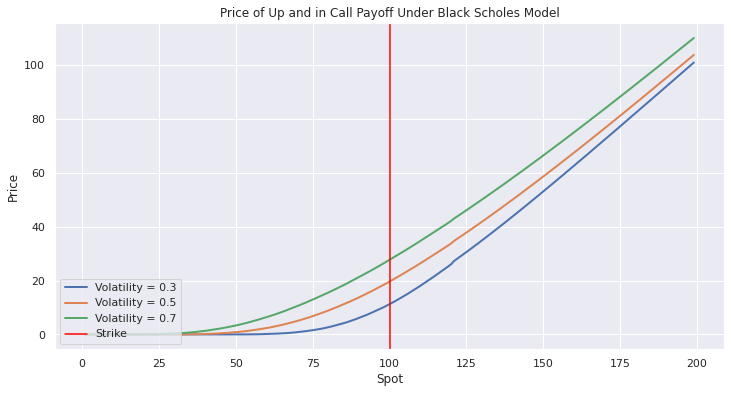

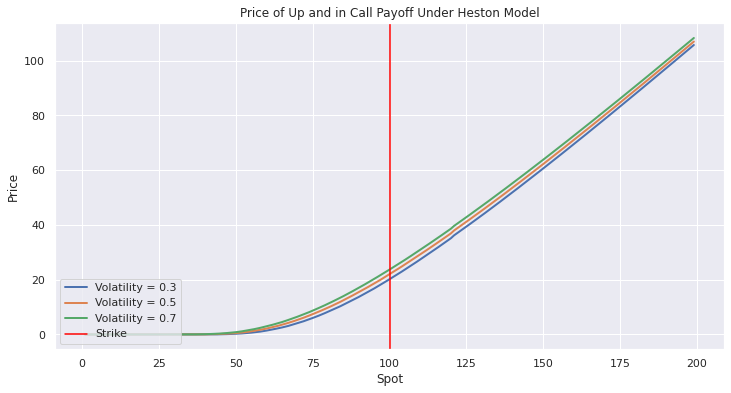

In [5]:
def compute_payoff(payoff, sigma = 0.3, model = 'bs'):
    prices = []
    if(model == 'bs'):
      for x in range(1,200):
          path = generate_paths_bs(x, sigma= sigma)
          prices.append(np.mean(payoff(path)))
    if(model == 'heston'):
      for x in range(1,200):
           path = generate_paths_heston(x, v_0 = sigma)[0]
           prices.append(np.mean(payoff(path)))
    return(prices)


prices_1 = compute_payoff(binary_call_payoff, sigma = 0.3, model = 'bs' )
prices_2 = compute_payoff(binary_call_payoff, sigma = 0.5, model = 'bs')
prices_3 = compute_payoff(binary_call_payoff, sigma = 0.7, model = 'bs')
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1, 200), prices_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1, 200), prices_2, linewidth=2, label = 'Volatility = 0.5')
plt.plot(range(1, 200), prices_3, linewidth=2, label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title("Price of Binary Call Under Black Scholes Model")
plt.xlabel('Spot')
plt.ylabel('Price')
plt.legend(loc = 'lower left')
plt.show()

prices_1 = compute_payoff(binary_call_payoff, sigma = 0.3, model = 'heston')
prices_2 = compute_payoff(binary_call_payoff, sigma = 0.5, model = 'heston')
prices_3 = compute_payoff(binary_call_payoff, sigma = 0.7, model = 'heston')
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1, 200), prices_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1, 200), prices_2, linewidth=2, label = 'Volatility = 0.5')
plt.plot(range(1, 200), prices_3, linewidth=2, label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title("Price of Binary Call Under Heston Model")
plt.xlabel('Spot')
plt.ylabel('Price')
plt.legend(loc = 'lower left')
plt.show()


prices_1 = compute_payoff(asian_call_payoff, sigma = 0.3, model = 'bs')
prices_2 = compute_payoff(asian_call_payoff, sigma = 0.5, model = 'bs')
prices_3 = compute_payoff(asian_call_payoff, sigma = 0.7, model = 'bs')
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1, 200), prices_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1, 200), prices_2, linewidth=2, label = 'Volatility = 0.5')
plt.plot(range(1, 200), prices_3, linewidth=2, label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title("Price of Asian Call Under Black Scholes Model")
plt.xlabel('Spot')
plt.ylabel('Price')
plt.legend(loc = 'lower left')
plt.show()

prices_1 = compute_payoff(asian_call_payoff, sigma = 0.3, model = 'heston')
prices_2 = compute_payoff(asian_call_payoff, sigma = 0.5, model = 'heston')
prices_3 = compute_payoff(asian_call_payoff, sigma = 0.7, model = 'heston')
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1, 200), prices_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1, 200), prices_2, linewidth=2, label = 'Volatility = 0.5')
plt.plot(range(1, 200), prices_3, linewidth=2, label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title("Price of Asian Call Under Heston Model")
plt.xlabel('Spot')
plt.ylabel('Price')
plt.legend(loc = 'lower left')
plt.show()

prices_1 = compute_payoff(up_and_in_call_payoff, sigma = 0.3, model = 'bs')
prices_2 = compute_payoff(up_and_in_call_payoff, sigma = 0.5, model = 'bs')
prices_3 = compute_payoff(up_and_in_call_payoff, sigma = 0.7, model = 'bs')
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1, 200), prices_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1, 200), prices_2, linewidth=2, label = 'Volatility = 0.5')
plt.plot(range(1, 200), prices_3, linewidth=2, label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title("Price of Up and in Call Payoff Under Black Scholes Model")
plt.xlabel('Spot')
plt.ylabel('Price')
plt.legend(loc = 'lower left')
plt.show()


prices_1 = compute_payoff(up_and_in_call_payoff, sigma = 0.3, model = 'heston')
prices_2 = compute_payoff(up_and_in_call_payoff, sigma = 0.5, model = 'heston')
prices_3 = compute_payoff(up_and_in_call_payoff, sigma = 0.7, model = 'heston')
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1, 200), prices_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1, 200), prices_2, linewidth=2, label = 'Volatility = 0.5')
plt.plot(range(1, 200), prices_3, linewidth=2, label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title("Price of Up and in Call Payoff Under Heston Model")
plt.xlabel('Spot')
plt.ylabel('Price')
plt.legend(loc = 'lower left')
plt.show()


In [6]:
def Delta(payoff, x, sigma = 0.3, model = 'bs'):
    '''
      Compute the Delta of Reverse Convertible
      Args:
          payoff:
            Payoff of the derivative
          x:
            Spot Price of the Underlying
          sigma:
            Volatility
          Model :
            Black Scholes or Heston
      Returns:
          The Delta of the Reverse Convertible in x
      '''
    step = 0.1
    if (model == 'bs'):
      path_plus =  generate_paths_bs(S = x * (1 + step),  sigma= sigma)
      path_sub =  generate_paths_bs(S = x * (1 - step),  sigma= sigma)

    if (model == 'Heston'):
      path_plus =  generate_paths_heston(S = x * (1 + step), v_0 = sigma)[0]
      path_sub =  generate_paths_heston(S = x * (1 - step), v_0 = sigma)[0]

    return( np.mean ( (payoff(path_plus)-payoff(path_sub)) / (2 * step * x) ) )

def Gamma(payoff, x, sigma = 0.3, model = 'bs'):
    '''
      Compute the Gamma of Reverse Convertible
      Args:
          payoff:
            Payoff of the derivative
          x:
            Spot Price of the Underlying
          sigma:
            Volatility
          Model :
            Black Scholes or Heston
      Returns:
          The Gamma of the Reverse Convertible in x
      '''
    step = 0.5
    if (model == 'bs'):
      path = generate_paths_bs(S = x, sigma = sigma)
      path_plus =  generate_paths_bs(S = x * (1 + step), sigma = sigma)
      path_sub =  generate_paths_bs(S = x * (1 - step),  sigma = sigma)

    if (model == 'Heston'):
      path = generate_paths_heston(S = x, v_0 = sigma)[0]
      path_plus =  generate_paths_heston(S = x * (1 + step), v_0 = sigma)[0]
      path_sub =  generate_paths_heston(S = x * (1 - step), v_0 = sigma)[0]

    return ( np.mean ( (payoff(path_plus)-2*payoff(path)+payoff(path_sub))/( (step*x)**2) ) )

def Vega(payoff, x, sigma = 0.3, model = 'bs'):
    '''
      Compute the Vega of Reverse Convertible
      Args:
         payoff:
            Payoff of the derivative
          x:
            Spot Price of the Underlying
          sigma:
            Volatility
          Model :
            Black Scholes or Heston
      Returns:
          The Vega of the Reverse Convertible in x
      '''
    step = 0.5
    if (model == 'bs'):
      path_plus =  generate_paths_bs(S = x, sigma = sigma*(1+step))
      path_sub =  generate_paths_bs(S = x, sigma = sigma*(1-step))
    
    if (model == 'Heston'):
      path_plus =  generate_paths_heston(S = x, v_0 = sigma*(1+step))[0]
      path_sub =  generate_paths_heston(S = x, v_0 = sigma*(1-step))[0]
    
    return ( np.mean ( (payoff(path_plus)-payoff(path_sub)) / (2*step*sigma) ) )


def Volga(payoff, x, sigma = 0.3, model = 'bs'):
    '''
      Compute the Volga
      Args:
          payoff:
            Payoff of the derivative
          x:
            Spot Price of the Underlying
          sigma:
            Volatility
          Model :
            Black Scholes or Heston
      Returns:
          The Volga of the Reverse Convertible in x
      '''
    step = 0.5 
    if (model == 'bs'):
      path = generate_paths_bs(S = x, sigma = sigma)
      path_plus =  generate_paths_bs(S = x, sigma = sigma * (1 + step))
      path_sub =  generate_paths_bs(S = x, sigma = sigma * (1 - step))

    if (model == 'Heston'):
      path = generate_paths_heston(S = x, v_0 = sigma)[0]
      path_plus =  generate_paths_heston(S = x, v_0 = sigma * (1 + step))[0]
      path_sub =  generate_paths_heston(S = x, v_0 = sigma * (1 - step))[0]
    
    return( np.mean(payoff(path_plus)-2*payoff(path)+payoff(path_sub))/( (step*sigma)**2) )

def Vanna(payoff, x, sigma = 0.3, model = 'bs'):
    '''
      Compute the Vanna of Reverse Convertible
      Args:
         payoff:
            Payoff of the derivative
          x:
            Spot Price of the Underlying
          sigma:
            Volatility
          Model :
            Black Scholes or Heston
      Returns:
          The Vanna of the Reverse Convertible in x
      '''
    step = 0.2

    x_plus = x * (1 + step)
    x_sub = x * (1 - step)
    sigma_plus = sigma * (1 + step)
    sigma_sub = sigma * (1 - step)

    if (model == 'bs'):
      path_plus =  generate_paths_bs(S = x_plus, sigma = sigma_plus)
      path_sub_plus = generate_paths_bs(S = x_sub, sigma = sigma_plus)
      path_plus_sub = generate_paths_bs(S = x_plus, sigma = sigma_sub)
      path_sub =  generate_paths_bs(S = x_sub, sigma = sigma_sub)

    if (model == 'Heston'):
      path_plus =  generate_paths_heston(S = x_plus, v_0 = sigma_plus)[0]
      path_sub_plus = generate_paths_heston(S= x_sub, v_0 = sigma_plus)[0]
      path_plus_sub = generate_paths_heston(S = x_plus, v_0 = sigma_sub)[0]
      path_sub =  generate_paths_heston(S = x_sub, v_0 = sigma_sub)[0]
   
    return( np.mean ( (payoff(path_plus) - payoff(path_sub_plus) - payoff(path_plus_sub) + payoff(path_sub) ) / ( x * sigma * (2* step)**2  ) ) )

In [7]:
def compute_greeks(payoff, sigma, model = 'bs'):
    '''
      Plot the greeks 
      Args:
        payoff:
          The Payoff of the derivative
      '''
    delta = []
    gamma = []
    vega = []
    volga = []
    vanna = []

    for x in range(1,200):
        delta.append(Delta(payoff, x,  sigma = sigma, model = model))
        gamma.append(Gamma(payoff, x, sigma = sigma, model = model))
        vega.append(Vega(payoff, x,  sigma = sigma, model = model))
        volga.append(Volga(payoff, x,  sigma = sigma, model = model))
        vanna.append(Vanna(payoff, x,  sigma = sigma, model = model))
    return(delta, gamma, vega, volga, vanna)



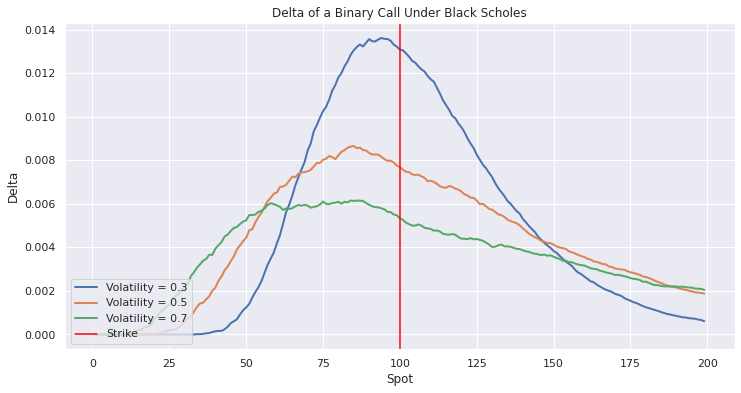

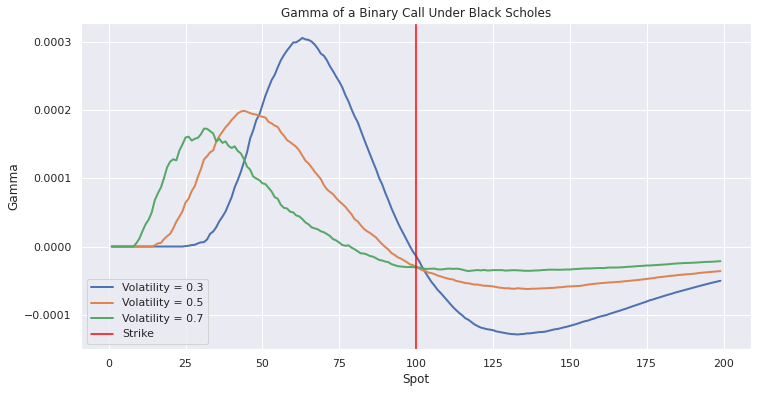

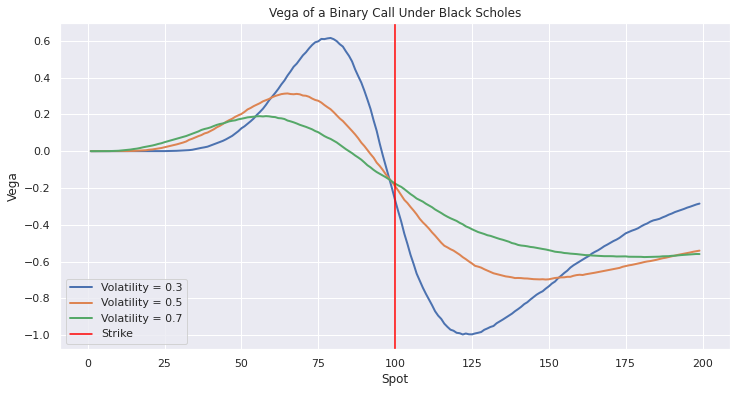

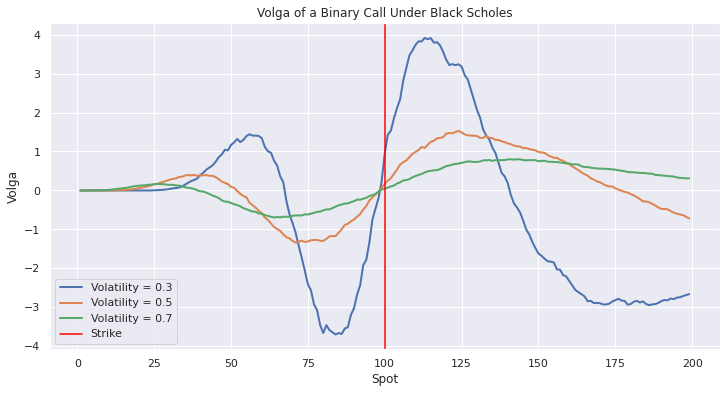

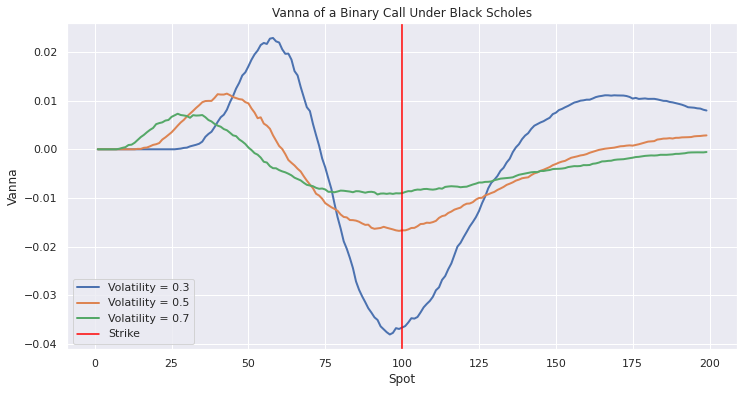

In [8]:
delta_1, gamma_1, vega_1, volga_1, vanna_1 = compute_greeks(binary_call_payoff, sigma = 0.3, model = 'bs')
delta_2, gamma_2, vega_2, volga_2, vanna_2 = compute_greeks(binary_call_payoff, sigma = 0.5, model = 'bs')
delta_3, gamma_3, vega_3, volga_3, vanna_3 = compute_greeks(binary_call_payoff, sigma = 0.7, model = 'bs')

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), delta_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), delta_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), delta_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Delta of a Binary Call Under Black Scholes')
plt.xlabel('Spot')
plt.ylabel('Delta')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), gamma_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), gamma_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), gamma_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Gamma of a Binary Call Under Black Scholes')
plt.xlabel('Spot')
plt.ylabel('Gamma')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), vega_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), vega_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), vega_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Vega of a Binary Call Under Black Scholes')
plt.xlabel('Spot')
plt.ylabel('Vega')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), volga_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), volga_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), volga_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Volga of a Binary Call Under Black Scholes')
plt.xlabel('Spot')
plt.ylabel('Volga')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), vanna_1, linewidth=2,  label = 'Volatility = 0.3')
plt.plot(range(1,200), vanna_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), vanna_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Vanna of a Binary Call Under Black Scholes')
plt.xlabel('Spot')
plt.ylabel('Vanna')
plt.legend(loc = 'lower left')
plt.show()

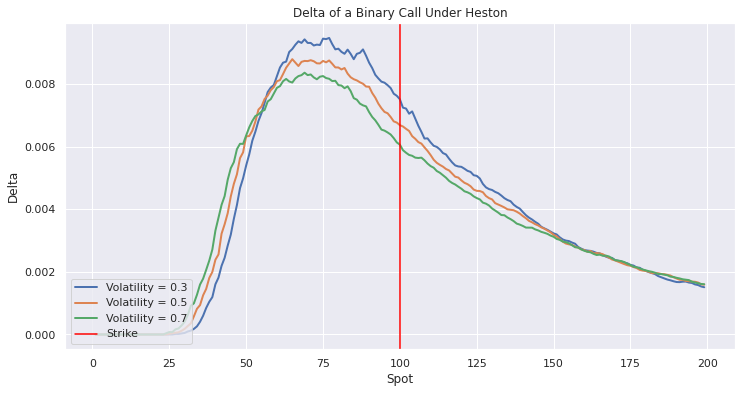

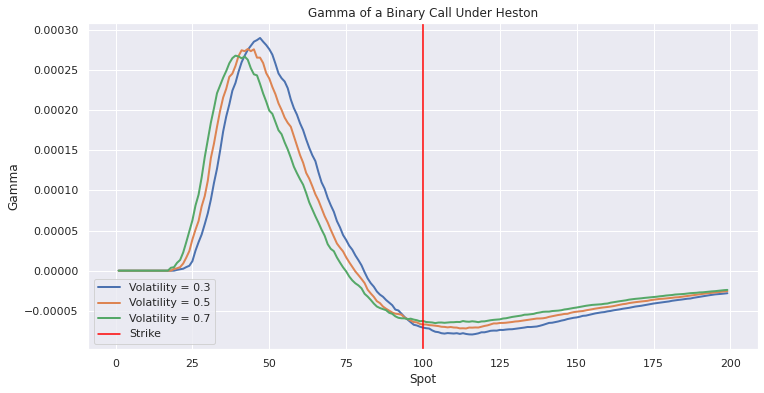

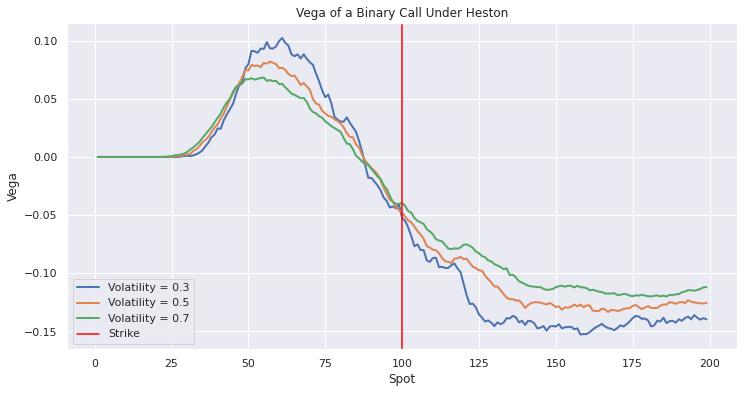

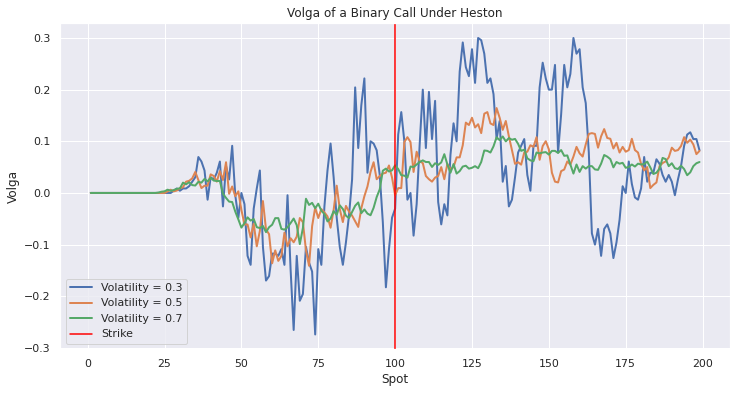

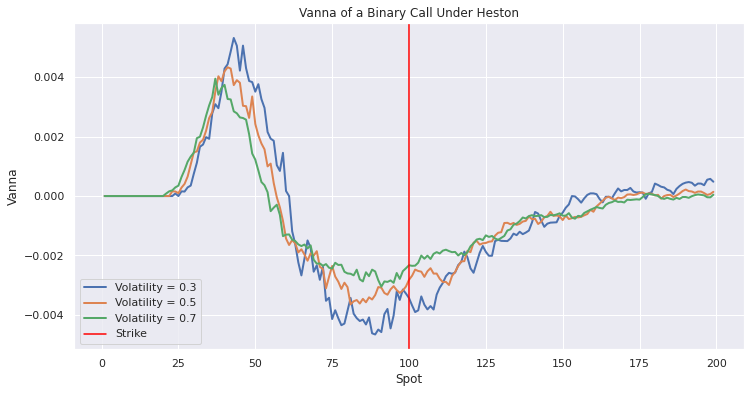

In [9]:
delta_1, gamma_1, vega_1, volga_1, vanna_1 = compute_greeks(binary_call_payoff, sigma = 0.3, model = 'Heston')
delta_2, gamma_2, vega_2, volga_2, vanna_2 = compute_greeks(binary_call_payoff, sigma = 0.5, model = 'Heston')
delta_3, gamma_3, vega_3, volga_3, vanna_3 = compute_greeks(binary_call_payoff, sigma = 0.7, model = 'Heston')

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), delta_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), delta_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), delta_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Delta of a Binary Call Under Heston')
plt.xlabel('Spot')
plt.ylabel('Delta')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), gamma_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), gamma_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), gamma_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Gamma of a Binary Call Under Heston')
plt.xlabel('Spot')
plt.ylabel('Gamma')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), vega_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), vega_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), vega_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Vega of a Binary Call Under Heston')
plt.xlabel('Spot')
plt.ylabel('Vega')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), volga_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), volga_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), volga_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Volga of a Binary Call Under Heston')
plt.xlabel('Spot')
plt.ylabel('Volga')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), vanna_1, linewidth=2,  label = 'Volatility = 0.3')
plt.plot(range(1,200), vanna_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), vanna_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Vanna of a Binary Call Under Heston')
plt.xlabel('Spot')
plt.ylabel('Vanna')
plt.legend(loc = 'lower left')
plt.show()

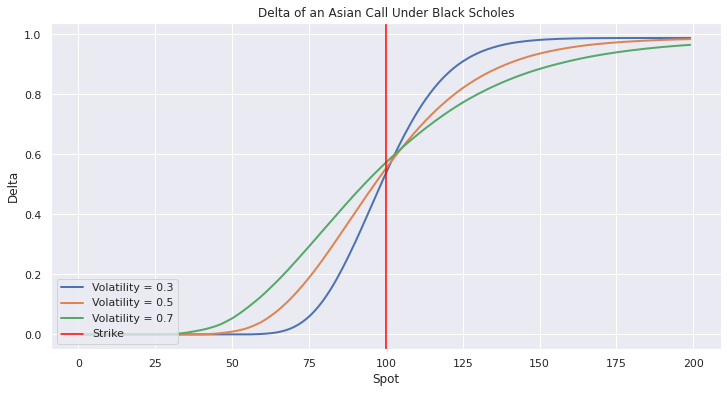

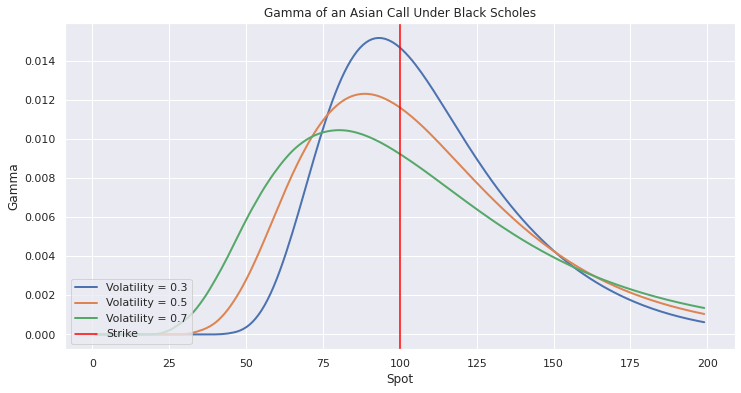

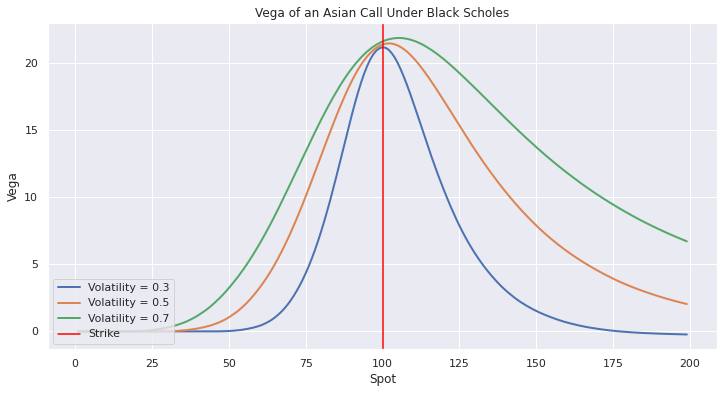

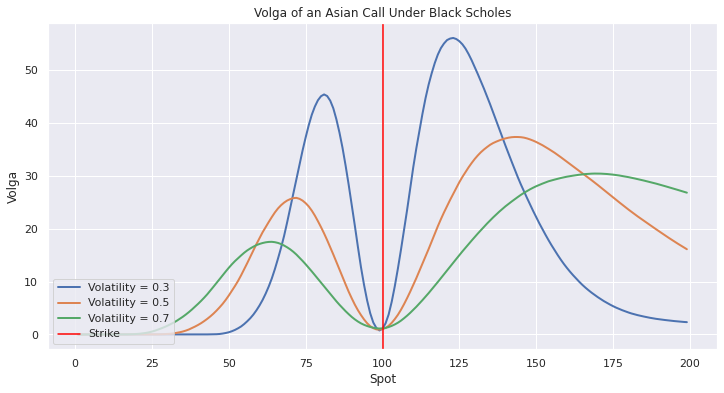

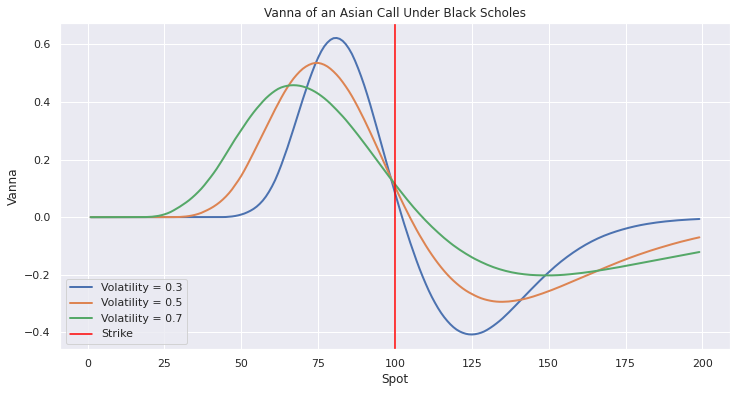

In [10]:
delta_1, gamma_1, vega_1, volga_1, vanna_1 = compute_greeks(asian_call_payoff, sigma = 0.3, model = 'bs')
delta_2, gamma_2, vega_2, volga_2, vanna_2 = compute_greeks(asian_call_payoff, sigma = 0.5, model = 'bs')
delta_3, gamma_3, vega_3, volga_3, vanna_3 = compute_greeks(asian_call_payoff, sigma = 0.7, model = 'bs')

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), delta_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), delta_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), delta_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Delta of an Asian Call Under Black Scholes')
plt.xlabel('Spot')
plt.ylabel('Delta')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), gamma_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), gamma_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), gamma_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Gamma of an Asian Call Under Black Scholes')
plt.xlabel('Spot')
plt.ylabel('Gamma')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), vega_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), vega_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), vega_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Vega of an Asian Call Under Black Scholes')
plt.xlabel('Spot')
plt.ylabel('Vega')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), volga_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), volga_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), volga_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Volga of an Asian Call Under Black Scholes')
plt.xlabel('Spot')
plt.ylabel('Volga')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), vanna_1, linewidth=2,  label = 'Volatility = 0.3')
plt.plot(range(1,200), vanna_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), vanna_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Vanna of an Asian Call Under Black Scholes')
plt.xlabel('Spot')
plt.ylabel('Vanna')
plt.legend(loc = 'lower left')
plt.show()

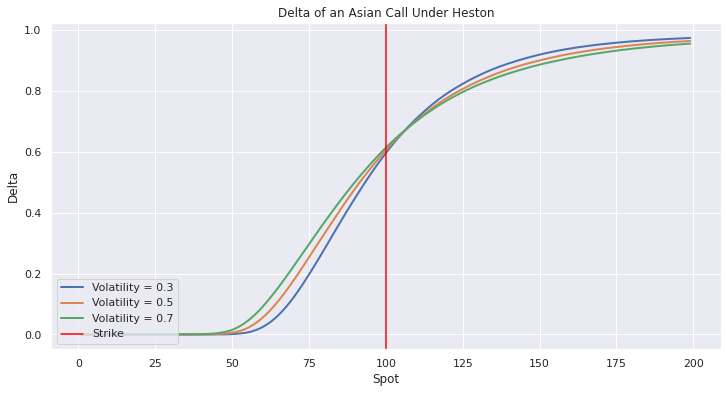

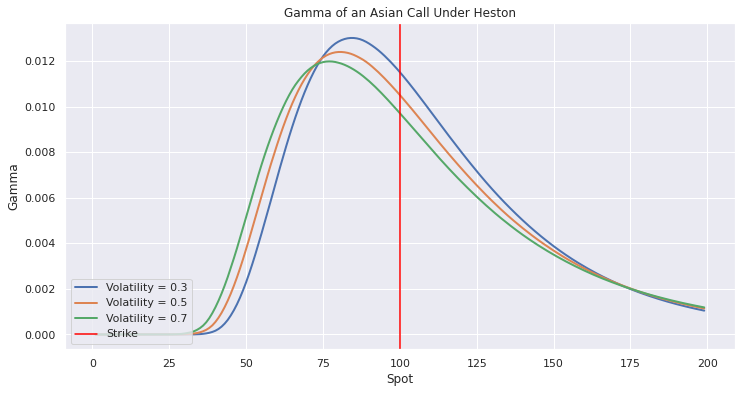

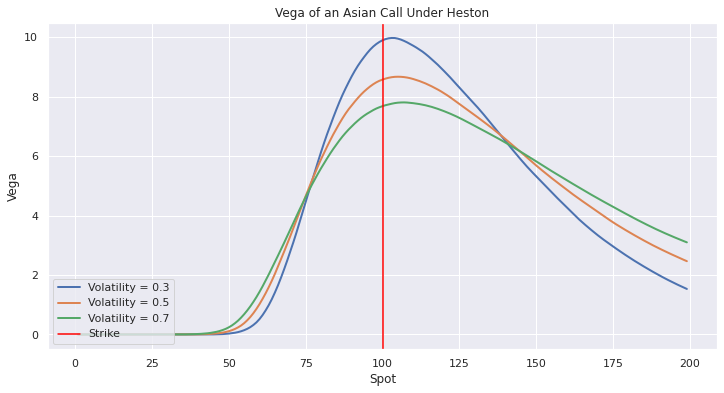

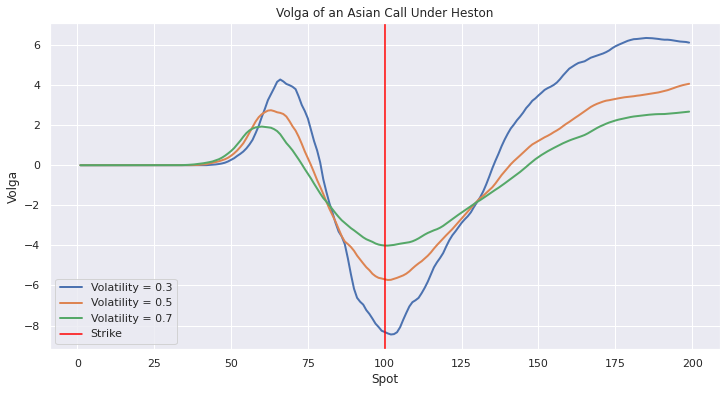

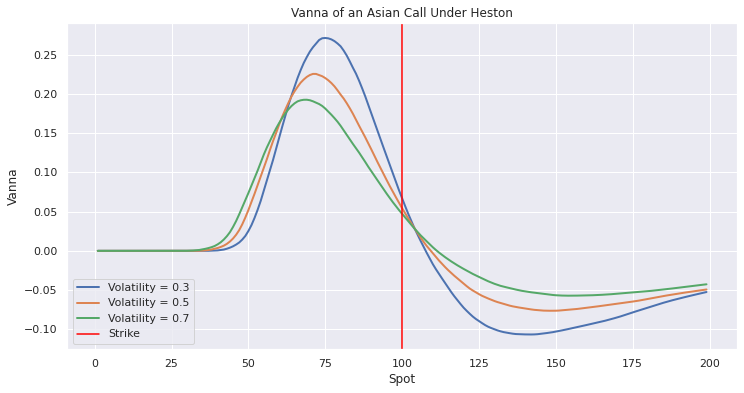

In [11]:
delta_1, gamma_1, vega_1, volga_1, vanna_1 = compute_greeks(asian_call_payoff, sigma = 0.3, model = 'Heston')
delta_2, gamma_2, vega_2, volga_2, vanna_2 = compute_greeks(asian_call_payoff, sigma = 0.5, model = 'Heston')
delta_3, gamma_3, vega_3, volga_3, vanna_3 = compute_greeks(asian_call_payoff, sigma = 0.7, model = 'Heston')

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), delta_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), delta_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), delta_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Delta of an Asian Call Under Heston')
plt.xlabel('Spot')
plt.ylabel('Delta')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), gamma_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), gamma_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), gamma_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Gamma of an Asian Call Under Heston')
plt.xlabel('Spot')
plt.ylabel('Gamma')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), vega_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), vega_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), vega_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Vega of an Asian Call Under Heston')
plt.xlabel('Spot')
plt.ylabel('Vega')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), volga_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), volga_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), volga_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Volga of an Asian Call Under Heston')
plt.xlabel('Spot')
plt.ylabel('Volga')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), vanna_1, linewidth=2,  label = 'Volatility = 0.3')
plt.plot(range(1,200), vanna_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), vanna_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.title('Vanna of an Asian Call Under Heston')
plt.xlabel('Spot')
plt.ylabel('Vanna')
plt.legend(loc = 'lower left')
plt.show()

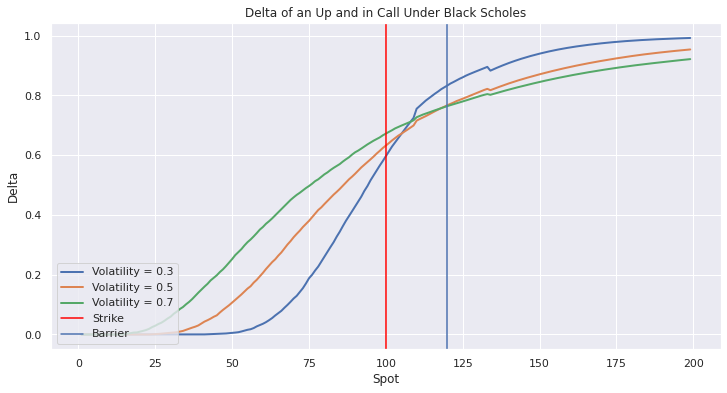

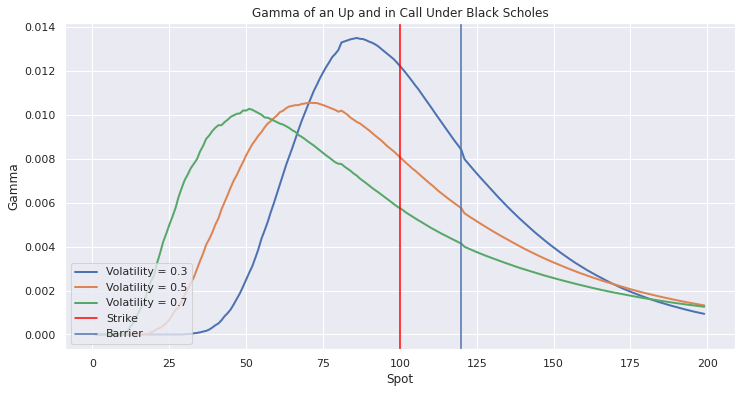

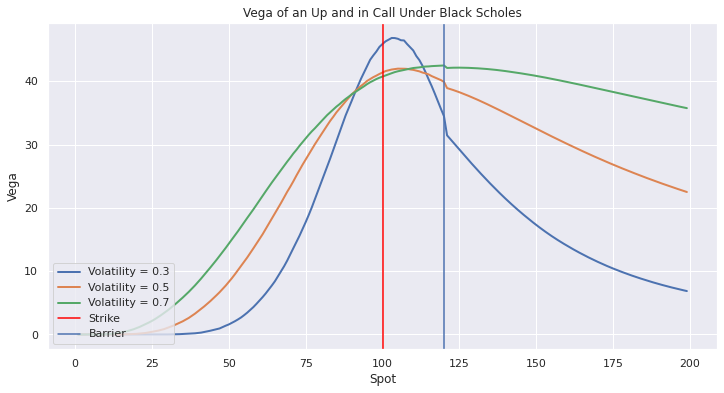

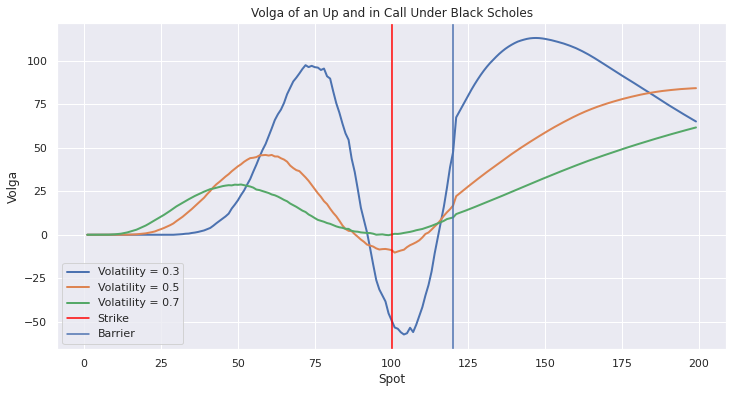

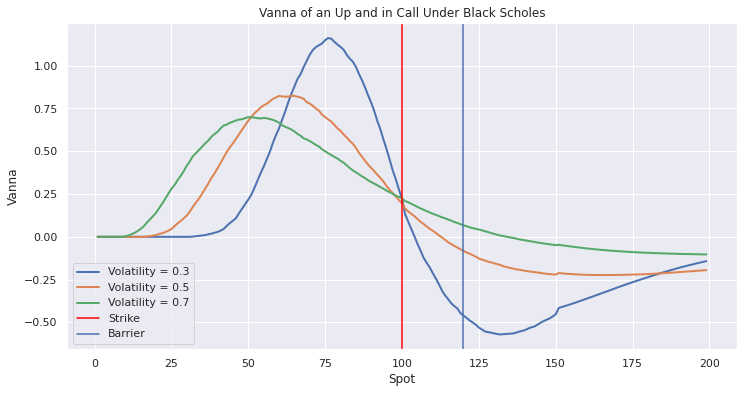

In [17]:
delta_1, gamma_1, vega_1, volga_1, vanna_1 = compute_greeks(up_and_in_call_payoff, sigma = 0.3, model = 'bs')
delta_2, gamma_2, vega_2, volga_2, vanna_2 = compute_greeks(up_and_in_call_payoff, sigma = 0.5, model = 'bs')
delta_3, gamma_3, vega_3, volga_3, vanna_3 = compute_greeks(up_and_in_call_payoff, sigma = 0.7, model = 'bs')

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), delta_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), delta_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), delta_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.axvline(x = 120, label = "Barrier")
plt.title('Delta of an Up and in Call Under Black Scholes')
plt.xlabel('Spot')
plt.ylabel('Delta')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), gamma_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), gamma_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), gamma_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.axvline(x = 120, label = "Barrier")
plt.title('Gamma of an Up and in Call Under Black Scholes')
plt.xlabel('Spot')
plt.ylabel('Gamma')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), vega_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), vega_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), vega_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.axvline(x = 120, label = "Barrier")
plt.title('Vega of an Up and in Call Under Black Scholes')
plt.xlabel('Spot')
plt.ylabel('Vega')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), volga_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), volga_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), volga_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.axvline(x = 120, label = "Barrier")
plt.title('Volga of an Up and in Call Under Black Scholes')
plt.xlabel('Spot')
plt.ylabel('Volga')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), vanna_1, linewidth=2,  label = 'Volatility = 0.3')
plt.plot(range(1,200), vanna_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), vanna_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.axvline(x = 120, label = "Barrier")
plt.title('Vanna of an Up and in Call Under Black Scholes')
plt.xlabel('Spot')
plt.ylabel('Vanna')
plt.legend(loc = 'lower left')
plt.show()

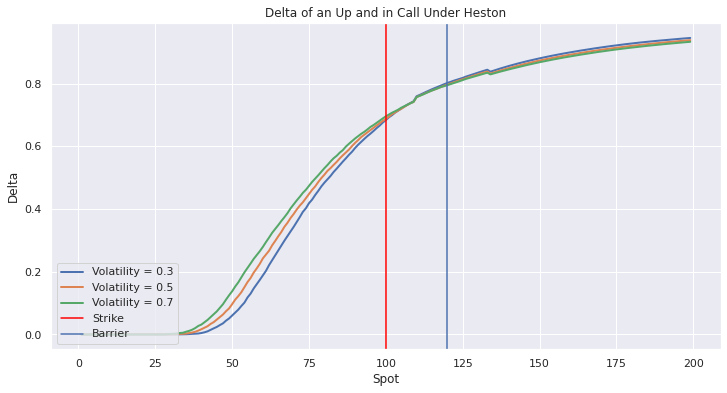

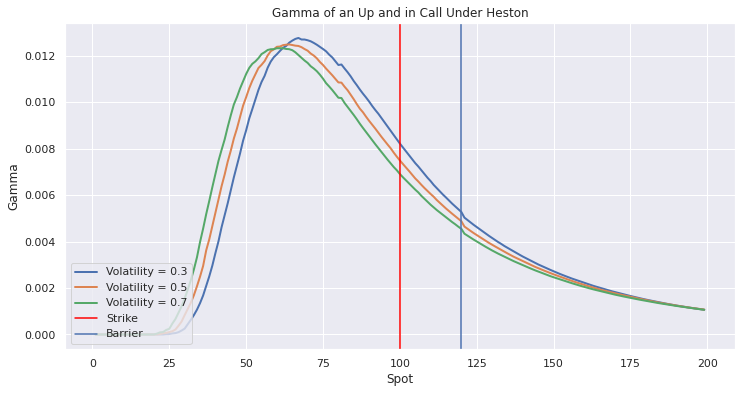

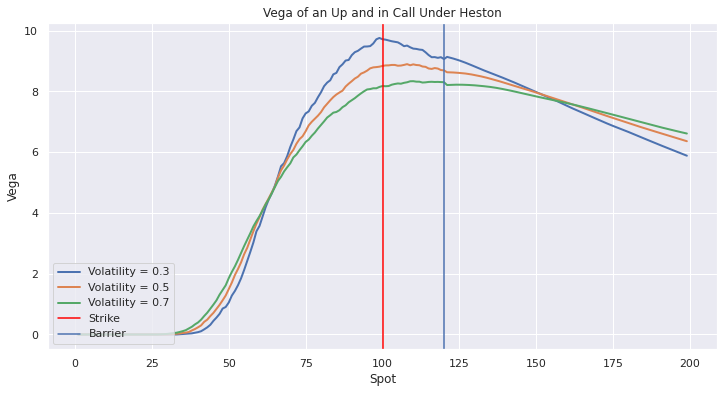

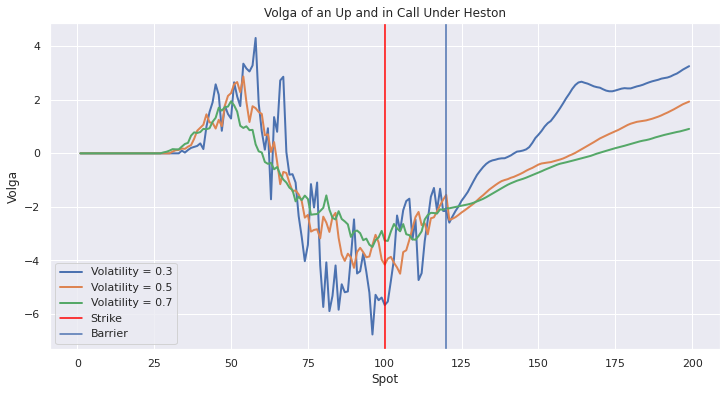

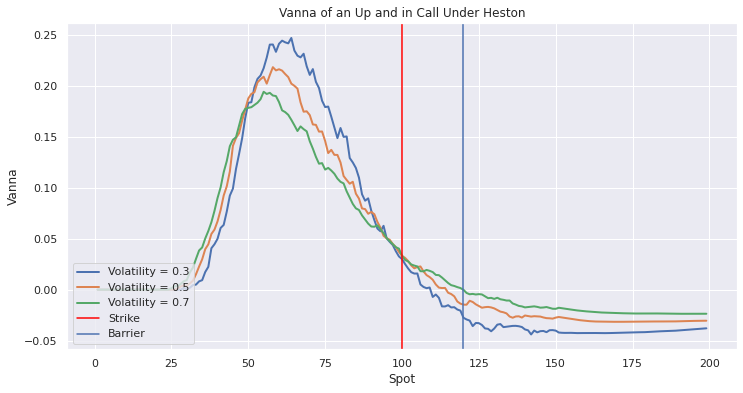

In [18]:
delta_1, gamma_1, vega_1, volga_1, vanna_1 = compute_greeks(up_and_in_call_payoff, sigma = 0.3, model = 'Heston')
delta_2, gamma_2, vega_2, volga_2, vanna_2 = compute_greeks(up_and_in_call_payoff, sigma = 0.5, model = 'Heston')
delta_3, gamma_3, vega_3, volga_3, vanna_3 = compute_greeks(up_and_in_call_payoff, sigma = 0.7, model = 'Heston')

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), delta_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), delta_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), delta_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.axvline(x = 120, label = "Barrier")
plt.title('Delta of an Up and in Call Under Heston')
plt.xlabel('Spot')
plt.ylabel('Delta')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), gamma_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), gamma_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), gamma_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.axvline(x = 120, label = "Barrier")
plt.title('Gamma of an Up and in Call Under Heston')
plt.xlabel('Spot')
plt.ylabel('Gamma')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), vega_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), vega_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), vega_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.axvline(x = 120, label = "Barrier")
plt.title('Vega of an Up and in Call Under Heston')
plt.xlabel('Spot')
plt.ylabel('Vega')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), volga_1, linewidth=2, label = 'Volatility = 0.3')
plt.plot(range(1,200), volga_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), volga_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.axvline(x = 120, label = "Barrier")
plt.title('Volga of an Up and in Call Under Heston')
plt.xlabel('Spot')
plt.ylabel('Volga')
plt.legend(loc = 'lower left')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(1,200), vanna_1, linewidth=2,  label = 'Volatility = 0.3')
plt.plot(range(1,200), vanna_2, linewidth=2,  label = 'Volatility = 0.5')
plt.plot(range(1,200), vanna_3, linewidth=2,  label = 'Volatility = 0.7')
plt.axvline(x = 100, color= "red", label = "Strike")
plt.axvline(x = 120, label = "Barrier")
plt.title('Vanna of an Up and in Call Under Heston')
plt.xlabel('Spot')
plt.ylabel('Vanna')
plt.legend(loc = 'lower left')
plt.show()